<img src="./img/HWNI_logo.svg"/>

# Lab B - Paired t-tests and Non-Parametric Tests

In [1]:
# makes our plots show up inside Jupyter
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

import util.utils as utils
import util.shared as shared

shared.format_plots()
shared.format_dataframes()

In this lab, we'll look at some more commonly-used and practical hypothesis tests than the simple example used in the
[hypothesis testing lab](../03 - Hypothesis Testing/Lab - Hypothesis Testing.ipynb).
In these tests, instead of collecting only one data point in our experimental condition, we'll collect multiple data points. All the tests considered in this lab -- paired and unpaired t-tests, non-parametric tests -- arise due to different choices of test statistic.

In this half of the lab, we'll be looking at using
[paired t-tests](https://en.wikipedia.org/wiki/Student%27s_t-test)
and at two non-parametric tests:
one is the randomization test described in the
[tutorial](Tutorial - Tests for 2-Sample Data.ipynb)
and the other is called the
[*Wilcoxon signed-rank test*](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test)

## Dataset Introduction

Certain types of nerve cells have the ability to regenerate a part of the cell that has been amputated. In an early study of this process, measurements were made on the nerves in the spinal cord of rhesus monkeys. Nerves emanating from the left side of the cord were cut, while nerves from the right side were kept intact. During the regeneration process, the amount of creatine phosphate (CP) was measured in the left and right portions of the spinal cord. You are interested in whether CP levels are different between the cut and control sides of the spinal cord. 

 *adapted from Samuels & Witmer, pg 387. Originally: Bodian (1947)*

**Q1** Why is a paired test appropriate for this dataset? What are we assuming about the data when we choose to use a paired t-test in particular?

<font color='#1874CD'> ** The measurements form natural pairs -- they are from the same organism. We are assuming that the measurements in each pair are drawn from normal distributions with equal (or at least similar) variances but possibly different means. **

**Q2** This experiment could've been run by severing both sides of the spinal cord in one set of monkeys and neither side in a control group. What makes the original experimental design likely superior?

<font color='#1874CD'> ** This design "controls for", aka allows us to ignore, individual differences in creatine phosphate expression, which can be a huge source of variation. It's appropriate if the only claim we're trying to make is that the intervention changes CP levels from a baseline, rather than absolutely. **

## Loading and Tidying Data

We begin by loading the data and taking a look at it. As is common in studies involving primates, the number of organisms used is quite small, so we can view all of the data at once.

In [2]:
cp_data = pd.read_csv("./data/3b.csv",index_col=None)

In [3]:
cp_data

,cpLevel,side,organismIdx
0,16.3,Control_R,1
1,4.8,Control_R,2
2,10.9,Control_R,3
3,14.2,Control_R,4
4,16.3,Control_R,5
5,9.9,Control_R,6
6,29.2,Control_R,7
7,22.4,Control_R,8
8,11.5,Regen_L,1
9,3.6,Regen_L,2


Notice, however, that this time our data is not "tidy" -- our "unit of observation" is one organism, but each row doesn't correspond to an organism. Instead, it corresponds to a measurement of creatine phosphate levels.

Luckily, our collaborator has included enough information that we can tidy this data up. The dataframe that we want to have has rows corresponding to values of `organismIdx` and two new columns, `Control_R` and `Regen_L`, which should be populated with values from `cpLevel`.

This operation of "reorganization" is common enough that pandas has a function to do it for us: `dataframe.pivot`. We tell is which column gives us the row `index`, which column gives us the new `columns`, and which column gives us the new `values`, like so:

In [4]:
tidy = cp_data.pivot(index="organismIdx", columns="side", values="cpLevel")
tidy

side,Control_R,Regen_L
organismIdx,,
1,16.3,11.5
2,4.8,3.6
3,10.9,12.5
4,14.2,6.3
5,16.3,15.2
6,9.9,8.1
7,29.2,16.6
8,22.4,13.1


Because the first format is always longer than the second, it's also called the *long format*, while the tidy format is also called the "wide format". As more and more folks get on board the tidy data train, these non-judgmental names for the formats are likely to fall out of favor.

For more on the philosophy of tidy data (written from an R perspective), check out this [paper by Hadley Wickham](http://www.jeannicholashould.com/tidy-data-in-python.html), developer of some of the most prominent stats packages for the R programming language. For some more practical examples of cleaning up messy data in Python, check out [this blog post by Jean Nicholas Hould](http://www.jeannicholashould.com/tidy-data-in-python.html).

## Visualizing Paired Data

If you need more convincing that tidy data formats are better, check out the code cell below. In just one line, it produces a histogram for each column and a scatterplot for each pair of columns -- what seaborn calls a `pairplot`. These can be very useful for exploring lots of pairwise relationships by eye very quickly.

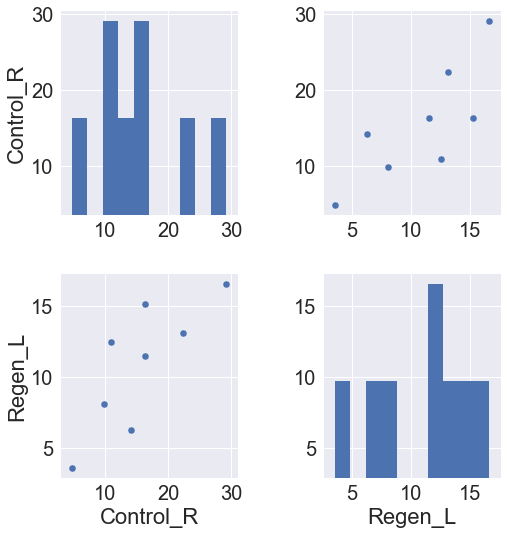

In [5]:
sns.pairplot(tidy, size=4, aspect=1);

As another, simpler, way to visualize the data, compute the differences between the control and regenerating sides and make a stripplot.

** Q3 ** Why do we take the difference? What does this have to do with our choice of the paired t-test?

<font color='#1874CD'> ** The difference is a new random variable over which our null and alternative hypotheses are more easily stated: our null hypothesis is that the mean of the differences is 0, and our alternative hypothesis are that the mean is at least as far from zero as the value we measured. **

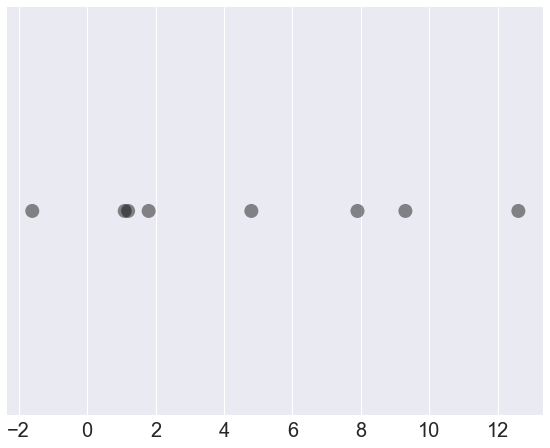

In [6]:
sns.stripplot(tidy.Control_R - tidy.Regen_L,
              size=14, alpha=0.45, color='black');

** Q4 **Based on this visualization, do you expect the result to be statistically significant or not? Why or why not?

<font color='#1874CD'> ** Yes, because only one of the differences is less than 0, while the majority are greater than 0. **

More common than either of these visualizations, at least in the biological literature, is a plot that shows the observations as neighboring stripplots with lines connecting pairs.

Run the cell below to generate just such a plot. Check out the `utils` module if you want to see how it's done -- since seaborn doesn't offer this as a basic plot, it requires a bit of matplotlib-fu.

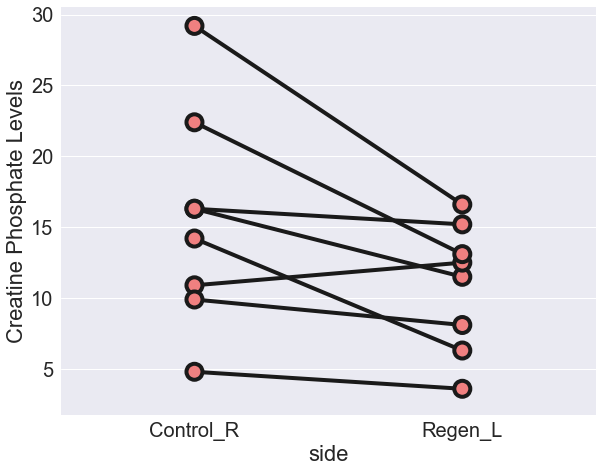

In [7]:
utils.difference_plot(tidy, ylabel="Creatine Phosphate Levels")

** Q5 ** What visual aspects of this plot indicate whether an effect is likely to be statistically significant or insignificant? Of the plots we made -- the pairplot scatter plots, the stripplot of differences, or the difference plot -- which do you prefer? Why? Which would you use in a publication?

<font color='#1874CD'>  

** The slopes of the lines are the salient visual feature. Most of the lines are pointing down, many of them with a much larger slope than the one line pointing up. **

** 
For data exploration, I prefer the scatter plot - it lets me see all of the data in a raw form, and I can easily see, by eye, that there is a strong correlation that indicates I should use a paired test. It's not as easy to tell whether there's a significant effect, however, without equalizing the axes and plotting the line `y=x`, which is a bit more involved.
**

** 
For publication, there's a strong pull towards the difference plot, in part because it is standard. It also lets you see, by eye, what the distribution of each group looks like as a scatterplot and the lines provide a quick-and-dirty estimate of the difference distribution. **

## Running a Paired t-Test

First, run the unpaired version of the t-test, as in the first half of the lab.

** Q6 ** Is the result significant at $\alpha$ = 0.05? (NB: Future uses of the term "significant" imply significant at this level of $\alpha$).

In [8]:
scipy.stats.ttest_ind(tidy.Control_R, tidy.Regen_L)

Ttest_indResult(statistic=1.4847824744326941, pvalue=0.159766872901516)

<font color='#1874CD'>  

**
No, it is not.
**

Scipy also has a paired version of the t-test: `scipy.stats.ttest_rel`, for `rel`ated measurements `t-test`. Run the paired test (the syntax for the function is much the same as for the unpaired test). 

** Q7 ** Is the result significant? If you got different answers for the two tests, explain why this is the case.

In [9]:
scipy.stats.ttest_rel(tidy.Control_R, tidy.Regen_L)

Ttest_relResult(statistic=2.6846726320793435, pvalue=0.031326495462755705)

<font color='#1874CD'>
**
Yes, the result is significant. We get different answers because the natural variability of organisms is larger than the variability due to the experimental manipulation, so the unpaired t-test gives us a different answer.
**

** Q8 **Say I gave you one measurement of creatine phosphate from a new organism's spinal cord. Based on your results, would you expect to be able to tell whether this measurement was from a spine undergoing regeneration? Why or why not? Does your answer change if I give you more measurements, all from different organisms in the same group?

<font color='#1874CD'>
**
I would not expect to tell the difference, because the variability between organisms is so high. If I received many measurements, I might be able to tell the difference, but it's unclear based on the small quantity of data we have. It might require a more sophisticated test.
**

** Q9 ** Now say I gave you two measurements of creatine phosphate, both from the same organism, one before and one after severing its spinal cord. Based on your results, do you expect to be able to tell which is which? Why or why not?

<font color='#1874CD'>

**
In this case, I think I have a good change of being able to tell which measurement comes from the regeneration state and which comes from the baseline state -- only one of the observed differences was negative, so I'd expect to be right in guessing that the higher value comes from the baseline state 7/8 times. 
**

## Non-Parametric Test: Wilcoxon

** Q9 ** What would be the argument for using a non-parametric test in this case? Are there any arguments against?

<font color='#1874CD'> **We aren't sure that the data was drawn, in both cases, from a normal distribution with the same variance. In fact, it appears that the left, regenerating side has higher variance, as we might expect from biology. Normality is difficult to test with such a small sample size, so a non-parametric test is safer. However, the power of such a test, if those assumptions are actually true, is much smaller, so we're more likely to have a false negative.**

Use the wilcoxon signed-rank test to perform a non-parametric paired test. Unfortunately, scipy doesn't implement an exact version of the signed-rank test for small sample sizes, so the p-value you calculate will be incorrect and you should receive a `"Warning: sample size too small for normal approximation"`.

** Q10 ** Despite this error, and the weaker power of the non-parametric test, do you report a significant difference based on the Wilcoxon test?

In [10]:
scipy.stats.wilcoxon(tidy.Control_R, tidy.Regen_L)

/Users/charlesfrye/anaconda3/envs/neur299/lib/python3.6/site-packages/scipy/stats/morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


WilcoxonResult(statistic=3.0, pvalue=0.035691900116804412)

<font color='#1874CD'> ** Yes, there is still a significant difference in CP levels. **

## Non-Parametric Test: Randomization

The
[tutorial](Tutorial - Tests for 2-Sample Data.ipynb)
describes the motivation for *randomization tests*,
a general class of non-parametric tests that can be used with a wide variety of test statistics,
including cases where parametric tests like the $t$-test fail.

Unfortunately, randomization tests are not implemented in the major Python statistical libraries.
One reason why is that it's pretty easy to write your own!
You just need to write

- a randomization, or shuffling, method appropriate to your null hypothesis
- a function that computes your test statistic
- a loop that will randomly shuffle your data and then compute the test statistic
- a function to calculate the $p$-value

The `util` module contains some code to shuffle dataframes.

The function to compute the test statistic appears in the cell below.
Notice that we can just change the statistic calculated by this function --
from `mean` to `median` or `max` or whatever we want --
and we'll get a new statistical test.
Much easier than implementing the Wilcoxon test AND the $t$-test!

In [11]:
def compute_test_statistic(tidy_dataframe, statistic='mean'):
    
    differences = tidy_dataframe.iloc[:,0] - tidy_dataframe.iloc[:,1]
    
    if statistic == 'mean':
        return np.mean(differences)
    elif statistic == 'median':
        return np.median(differences)
    elif statistic == 'max':
        return np.max(differences)

In [12]:
observed_test_statistic = compute_test_statistic(tidy, statistic = 'mean')

The loop to draw from the sampling distribution of the test statistic
under the null distribution appears in the cell below.
We just repeatedly shuffle the original data frame and
compute the test statistic,
storing the results in the array
`null_test_statistics`.

In [13]:
num_shuffles = 1000 # how many samples do we draw from the null distribution?

null_test_statistics = np.zeros(num_shuffles) # pre-allocate some memory to store the results of these samples

for shuffle_idx in range(num_shuffles):
    #first we shuffle the dataframe
    shuffled_df = utils.make_shuffle(tidy)
    #then we compute the test statistic and add it to our array
    null_test_statistics[shuffle_idx] = compute_test_statistic(shuffled_df, statistic = 'mean')

Lastly, we need to calculate the $p$-value.
For a one-tailed test, this is super easy!
We just need to calculate the fraction of times
that the test statistic after shuffling was at least as high
as it was before shuffling.

We can do this in one line of Python:
first, we get a Boolean array
(an array of `True`s and `False`s)
using the `>=` operator.
This array has a `True` wherever the value in the 
`null_test_statistic` array
was at least as large as the
`observed_test_statistic`.

We then calculate the mean of that array using
`np.mean`.
Since `True` is treated as a `1`
and `False` is treated as a `0`,
taking the average value gives us the fraction
of values that were `True` --
the fraction of times the test statistic calculated from a shuffled data frame
was higher than the one we calculated from our data.

In [14]:
np.mean(null_test_statistics >= observed_test_statistic)

0.025999999999999999

#### Q11 Is the result significant according to the randomization test?

<font color='#1874CD'> ** Yes, the result is significant at the $\alpha$=0.05 level. **

#### Q12 Change the argument `statistic` to `median` in both cells above. Is the result significant?

<font color='#1874CD'> ** Yes, the result is significant at the $\alpha$=0.05 level. **

#### Q13 Explain the benefits and drawbacks of the randomization test relative to a) parametric methods and b) test-statistic-specific non-parametric methods like the Wilcoxon test.

<font color='#1874CD'> ** As a non-parametric test, the randomization test makes fewer assumptions than an equivalent parametric test, but sacrifices some power in the case that those assumptions are correct. **

** Compared to other non-parametric tests, randomization tests are easier to implement and easier to understand, but sometimes have less power. **